In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

=> file_path = Path('') \
=> df = pd.read_csv(file_path, index_col='date', parse_dates=True)

=> fig, ax = plt.subplots()\
=> df.plot(ax=ax)\
=> plt.show()\
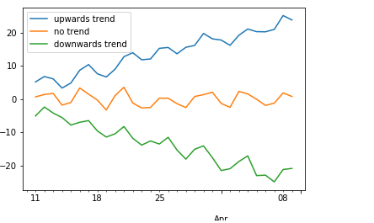 \
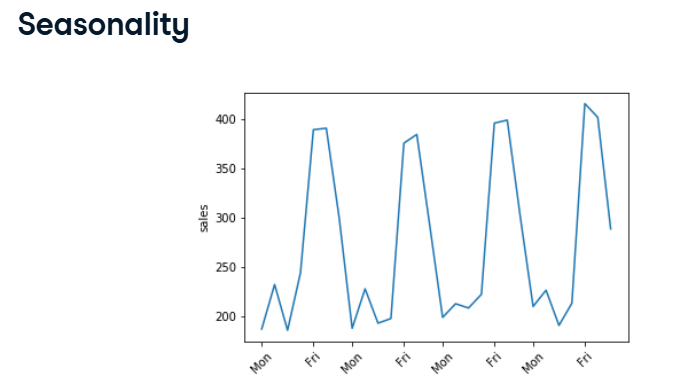 \
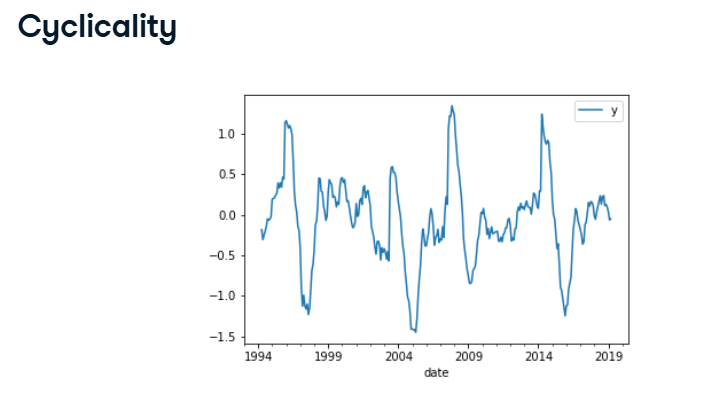

White Noise is a series of measurements, where each values is uncorrelated with previous values. In other words, White Noise has uncorrelated values.

Stationarity means that the distribution of the data does not change with time.\
In below image: Autocorrelation is shown in both stationarities: Stationary and Not Stationary.

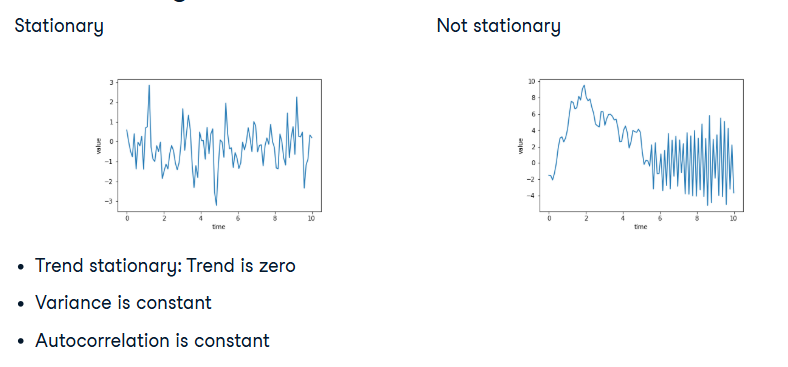

### Train-Test split
=> df_train = df.loc[:'2025'] \
=> df_test = df.loc['2026':]

# Class:1 ARIMA Models 

In [11]:
file_path = Path('datasets//candy_production.csv')

In [13]:
df = pd.read_csv(file_path, index_col='date', parse_dates=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564 entries, 1972-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPG3113N  564 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


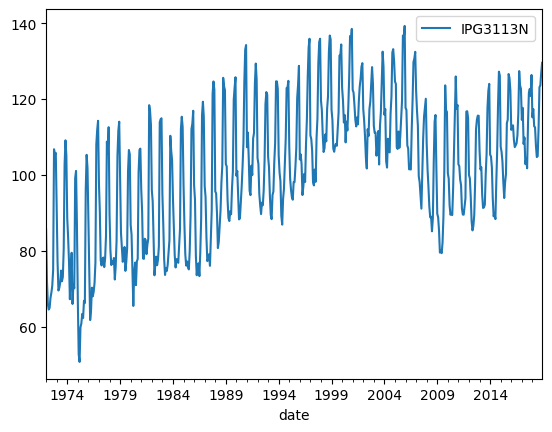

In [19]:
fig, ax = plt.subplots()
df.plot(ax=ax)
plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller

In [23]:
adfuller(df.IPG3113N) 

(-1.7760153075016099,
 0.39243275007140055,
 14,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3094.828881317046)

In [25]:
df_stationary = df.diff().dropna()

In [27]:
df_stationary.head(2)

,IPG3113N
date,
1972-02-01,-13.857405
1972-03-01,-5.792594


In [29]:
adfuller(df_stationary.IPG3113N) 

(-6.175912489755707,
 6.631549159333836e-08,
 13,
 549,
 {'1%': -3.4423174665535385,
  '5%': -2.866818952732754,
  '10%': -2.569581505602171},
 3091.3123583091397)

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [35]:
model = ARIMA(df_stationary.IPG3113N, order = (2, 0, 1))
results = model.fit()

In [37]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               IPG3113N   No. Observations:                  563
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1960.059
Date:                Sun, 02 Mar 2025   AIC                           3930.119
Time:                        06:03:30   BIC                           3951.785
Sample:                    02-01-1972   HQIC                          3938.577
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0544      0.558      0.097      0.922      -1.039       1.148
ar.L1         -0.6060      0.045    -13.455      0.000      -0.694      -0.518
ar.L2          0.3939      0.045      8.754      0.0

---
Model has AR-lag-1 and AR-lag-2 coefficients.\
`sigma2` is the variance of the shock terms.

`ARMAX` = ARMA + linear regression
- Exogenous ARMA (Use external variables as well as time series)

Ex: Productivity <- sleep as exog. A useful exogenous variable could be the amount of sleep you got the night before. Since this might affect your productivity. If more sleep made you more productive then the coefficient x-one would be positive.

=> model = ARIMA(df.productivity, order = (2, 0, 1), exog = df.hours_sleep)

In [115]:
# applied asfreq('D')

In [53]:
df_stationary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 563 entries, 1972-02-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   IPG3113N  563 non-null    float64
dtypes: float64(1)
memory usage: 25.0 KB


In [55]:
forecast = results.get_prediction(start = -25) # start from 25 days backward 
# we make predictions for the last 25 entries of the training data.

In [57]:
mean_forecast = forecast.predicted_mean
# The central value of the forecast is stored in the predicted_mean attribute of the
# forecast object. This predicted mean is a pandas series

In [59]:
mean_forecast.head()

2016-12-01    1.684732
2017-01-01   -3.449162
2017-02-01   -0.032422
2017-03-01   -1.892743
2017-04-01   -0.489131
Freq: MS, Name: predicted_mean, dtype: float64

In [61]:
confidence_intervals = forecast.conf_int()
# to get the lower and upper limits on the values of our predictions

In [63]:
confidence_intervals.head()

,lower IPG3113N,upper IPG3113N
2016-12-01,-13.691080,17.060544
2017-01-01,-18.824974,11.926649
2017-02-01,-15.408233,15.343388
2017-03-01,-17.268553,13.483067
2017-04-01,-15.864940,14.886679


=> plt.figure()\
=> plt.plot(\
=>     df_stationary,\
=>     mean_forecast.values,\
=>     color = 'red',\
=>     label = 'forecast'\
=> )\
=> plt.fill_between(dates, lower_limits, upper_limits, color='pink')\
=> plt.show()

<Axes: >

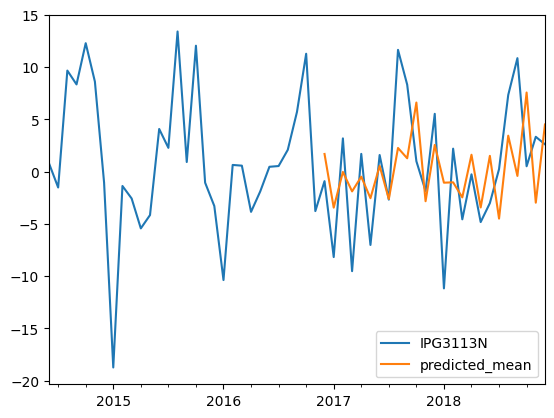

In [65]:
pd.concat([df_stationary['2014-06-01':], mean_forecast], axis = 1).plot() # loc['2020']

In [67]:
# Making dynamic predictions
results = model.fit()
forecast = results.get_prediction(start = -25, dynamic = True)

In [69]:
mean_forecast = forecast.predicted_mean

In [71]:
confidence_intervals = forecast.conf_int()

<Axes: >

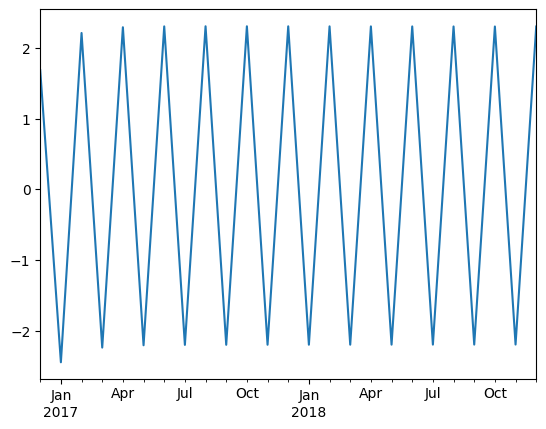

In [73]:
mean_forecast.plot()

In [75]:
# Forecasting out of sample
forecast = results.get_forecast(steps = 20)

In [77]:
mean_forecast = forecast.predicted_mean

In [79]:
confidence_intervals = forecast.conf_int()

<Axes: >

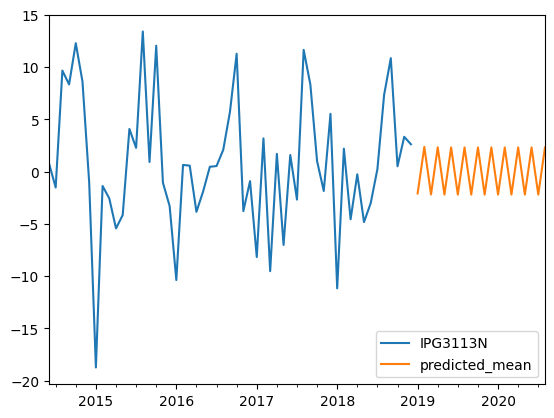

In [81]:
pd.concat([df_stationary['2014-06-01':], mean_forecast], axis = 1).plot() # loc['2020']

In [83]:
# Reconstructiong original time series after differencing
diff_forecast = results.get_forecast(steps=10).predicted_mean
from numpy import cumsum
mean_forecast = cumsum(diff_forecast) + df_stationary.iloc[-1,0]

In [85]:
mean_forecast

2019-01-01    0.523289
2019-02-01    2.882666
2019-03-01    0.696560
2019-04-01    3.016482
2019-05-01    0.815519
2019-06-01    3.128903
2019-07-01    0.926051
2019-08-01    3.238005
2019-09-01    1.035274
2019-10-01    3.346592
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: >

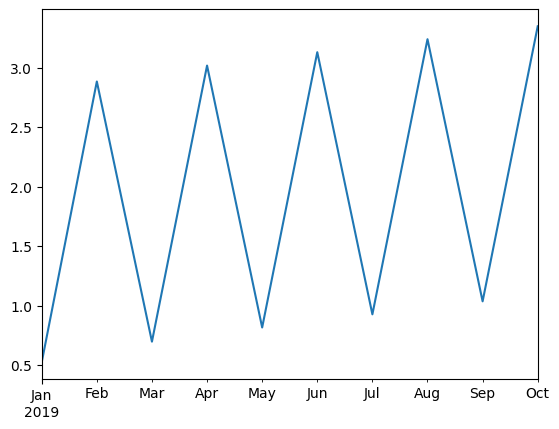

In [87]:
mean_forecast.plot()

After you do residual checks to check if a model is good or not
#### Mean Absolute Error
How far are the predictions from the real values?

In [99]:
import numpy as np

In [95]:
residuals = results.resid

In [103]:
mae = np.mean(np.abs(residuals))
mae

5.935712160428494

Whether MAE = 5.98 is good or bad depends on the scale of your data.\
If your values are small (e.g., in the range of 10-20), 5.98 is high (bad).\
If your values are large (e.g., in the range of 500-1000), 5.98 is low (good).

#### Plot diagnostics
If the model fits well the residuals will be white Gaussian noise

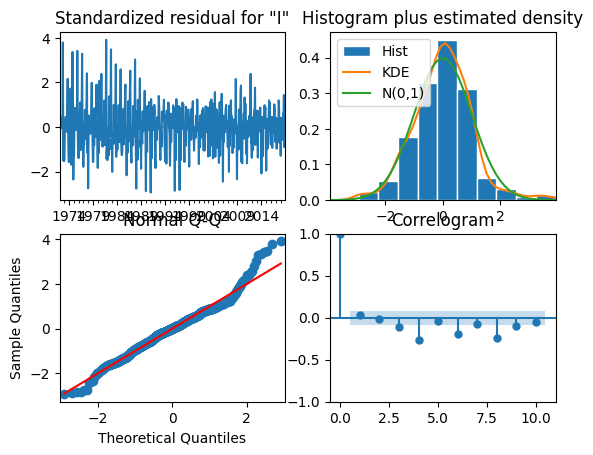

In [106]:
results.plot_diagnostics()
plt.show()

#### Correlogram
The last plot is the correlogram, which is just an ACF plot of the residuals rather than the data. 95% of the correlations for lag greater than zero should not be significant. If there is significant correlation in the residuals, it means that there is information in the data that our model has not captured.

In [117]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               IPG3113N   No. Observations:                  563
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1960.059
Date:                Sun, 02 Mar 2025   AIC                           3930.119
Time:                        06:14:35   BIC                           3951.785
Sample:                    02-01-1972   HQIC                          3938.577
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0544      0.558      0.097      0.922      -1.039       1.148
ar.L1         -0.6060      0.045    -13.455      0.000      -0.694      -0.518
ar.L2          0.3939      0.045      8.754      0.0

`Prob(Q)` -> p-value for Null Hypothesis that residuals are uncorrelated.\
`Prob(JB)` -> p-value for Null Hypothesis that residuals are normal.

### Box-Jenkins method
- `---Identification`
- Is the time series stationary?
- What differencing will make it stationary?
- What transforms will make it stationary?
- What values of p and q are most promising?
- `---Identification tools`
- Plot the time series: `df.plot()`
- ADF test: `adfuller()`
- Use Transforming and/or differencing: `df.diff(), np.log(), np.sqrt()`
- Plot ACF/PACF: `plot_acf(), plot_pacf()`
- `---Estimation`
- Use the data to train the model coefficients
- Done for us using `model.fit()`
- Choose between models using AIC and BIA: `results.aic, results.bic`
- `---Decision`
- `---Repeat until find a better model`
- `---Production`
- Ready to make forecasts: `results.get_forecast()`

## Seasonal Time Series
Has predictable and repeated patterns\
Repeats after any amount of time

<Axes: xlabel='date'>

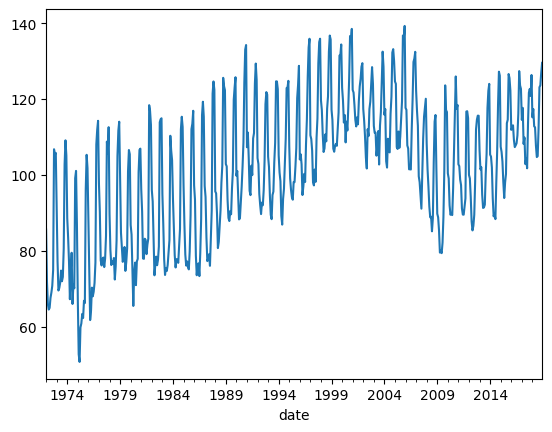

In [141]:
df.IPG3113N.plot()

time series = trend + seasonal + residual

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [148]:
decomp_results = seasonal_decompose(df.IPG3113N, period = 12)

`period` parameter -> the number of data points in each repeated cycle.\
Ex: here our cycle repeats every 12 steps.

In [154]:
type(decomp_results)

statsmodels.tsa.seasonal.DecomposeResult

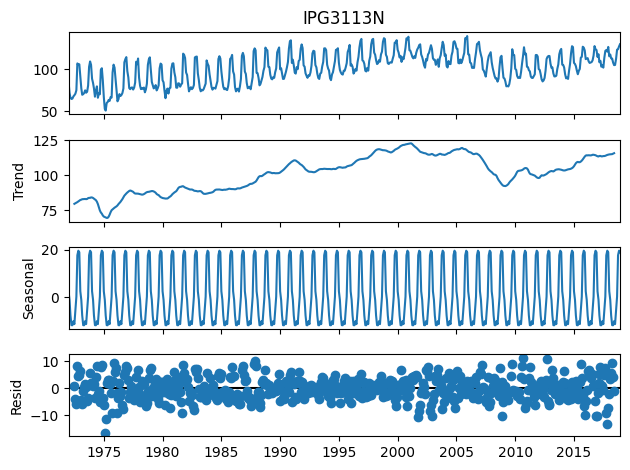

In [156]:
decomp_results.plot()
plt.show()

In order to decompose the data, we need to know how often the cycles repeat. Often, you will be able to guess this, but we can also use the ACF to identify the period.

In [158]:
import statsmodels.graphics.tsaplots as sgt

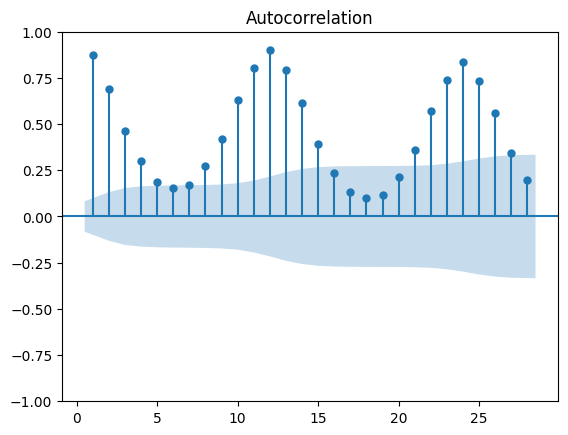

In [163]:
sgt.plot_acf(df.IPG3113N, zero=False)
plt.show()

=> Look, data is not stationary, so beforehand, I am using ACF to find out the seasonality periods.\
=> The ACF shows a periodic correlation pattern.\
=> To find the period we look for a lag greater than one, which is a peak in the ACF plot.\
=> Here, there is a peak at 12 lags and so this means that the seasonal component repeats every 12 time steps.

=> Sometimes, it can be hard to tell by eye whether a time series is seasonal or not. This is where the ACF is particularly useful.

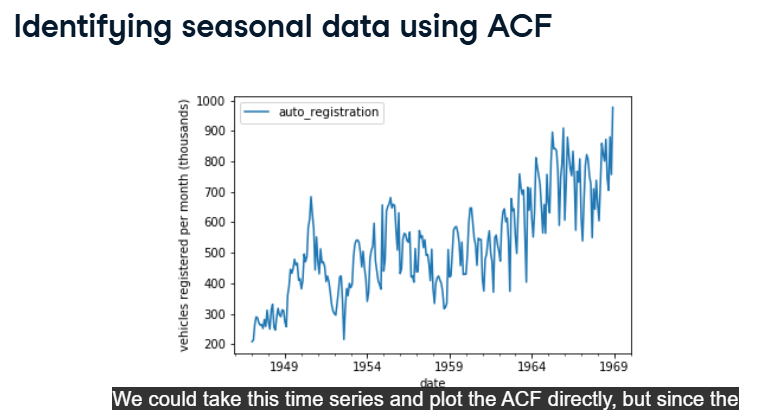

Ex: auto_registration csv dataset.\
We could take this time series and plot the ACF directly, but since the time series is non-stationary, the ACF plot will be cleaer if we detrend it first. \
We have detrended time series before by taking the difference. However, this time we are only trying to find the period of the time series, and the ACF plot will be clearer if we just subtract the rolling mean.\
We calculate the rolling mean using the DataFrame's `.rolling(N).mean()` method where we wass the window size and also use the .mean() method. Any large window size N, will work for this.\
We subtract this from the original time series and drop the NA values.\
The time series is now stationary and it will be easier to interpret the ACF plot.

In [172]:
df = df - df.rolling(100).mean()

In [174]:
df = df.dropna()

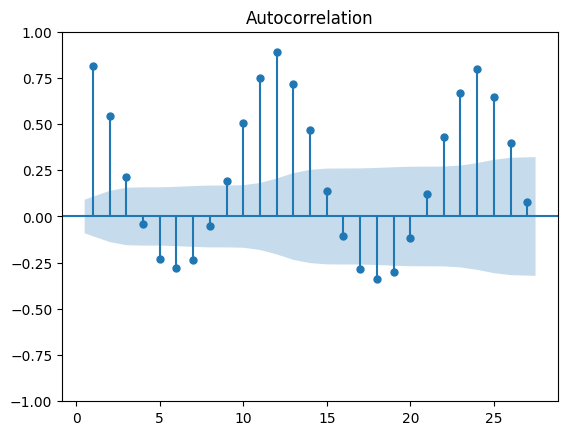

In [186]:
sgt.plot_acf(df.dropna(), zero=False)
plt.show()

We can clearly see that there is a seasonal period of 12 steps. Ex: above data is in monthly frequency, so each lag represents a month, lag 12 is the peak which means month 12 is the peak, hence cycle period is 12 months (lags).

=> Since the data is seasonal, we will always have correlated residuals left if we try to fit an ARIMA model to it. Ex: when I run plot_diagnostics, I got correlogram results which were not in blue area, ideally they must be inside but in my model they were monstly ouside. This means that ARIMA model was not enough hence need to use Seasonal ARIMA.

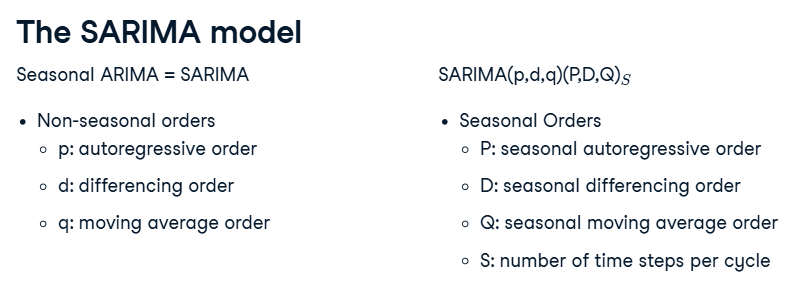

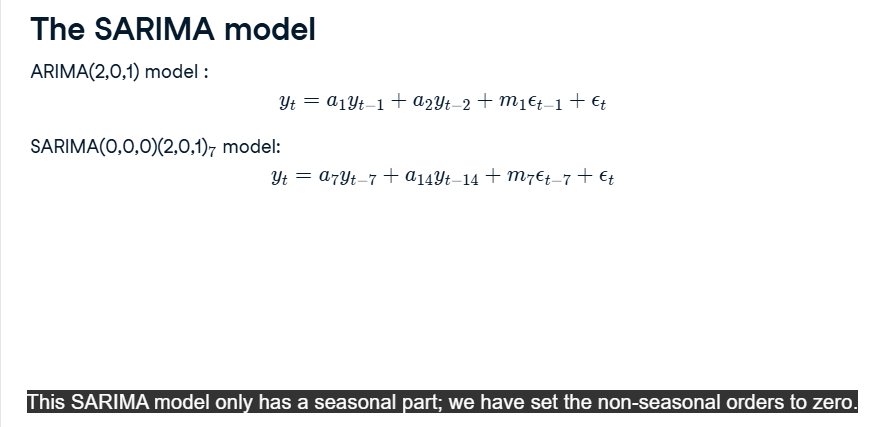

This particular SARIMA model will be able to capture seasonal weekly patterns, but won't be able to capture local, day-to-day patterns. If we construct a SARIMA model and include non-seasonal orders as well, then we can capture both of these patterns. (non-seasonal and seasonal orders).

#### Fitting a SARIMA model

In [204]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [206]:
# model = SARIMAX(df.Revenue, order = (p, d, q), seasonal_order = (P, D, Q, S))

In [208]:
# results = model.fit()

#### Seasonal Differencing

To make a time series stationary we may need to apply seasonal differencing.\
In seasonal differencing, instead of subtracting the most recent time series value, we subtract the time series value from one cycle ago.

In [225]:
# take the seasonal difference
df_diff = df.diff(1).dropna()

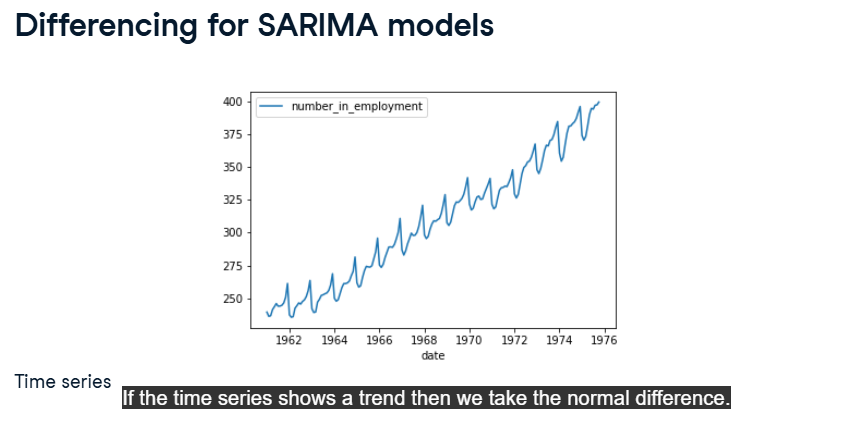
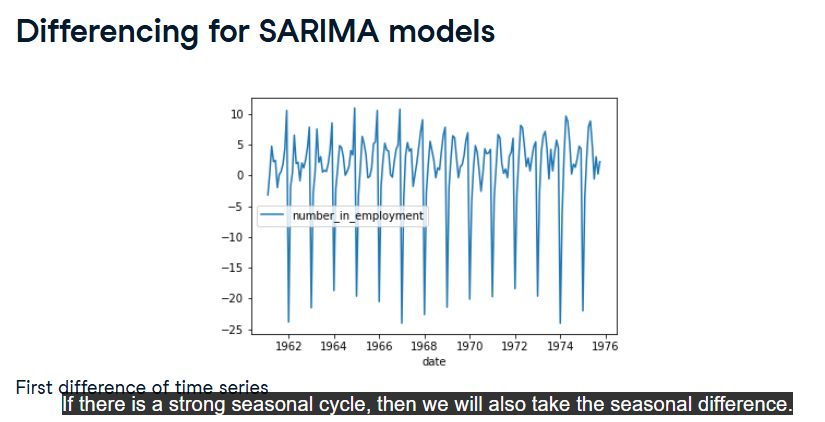
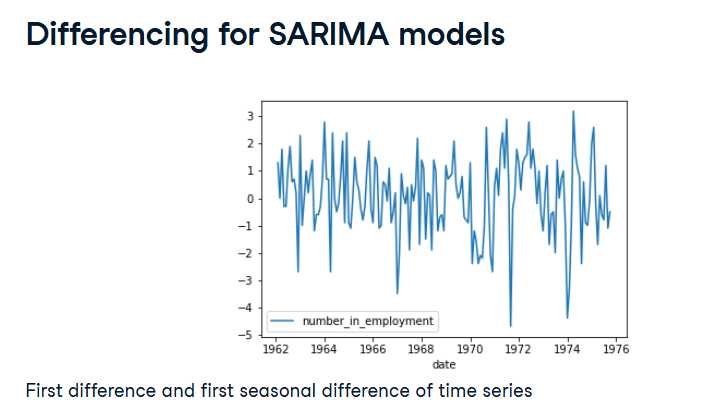

In [231]:
adfuller(df_diff.dropna())

(-5.878056975083332,
 3.125408841885974e-07,
 13,
 450,
 {'1%': -3.444965543297668,
  '5%': -2.8679842369272976,
  '10%': -2.5702025382716047},
 2476.8844089334425)

---
=> To find the non-seasonal orders, we plot the ACF and the PACF of the differenced time series.

---

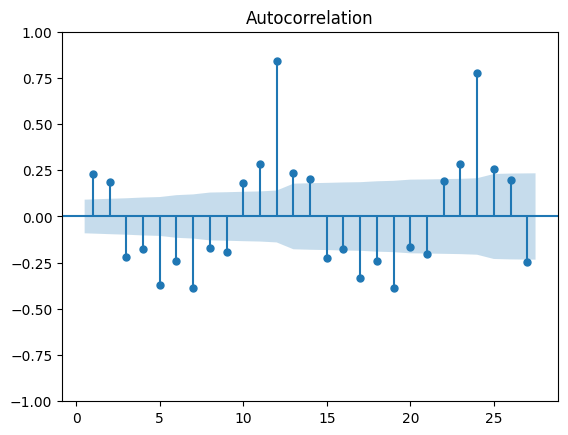

In [248]:
sgt.plot_acf(df_diff, zero = False)
plt.show()

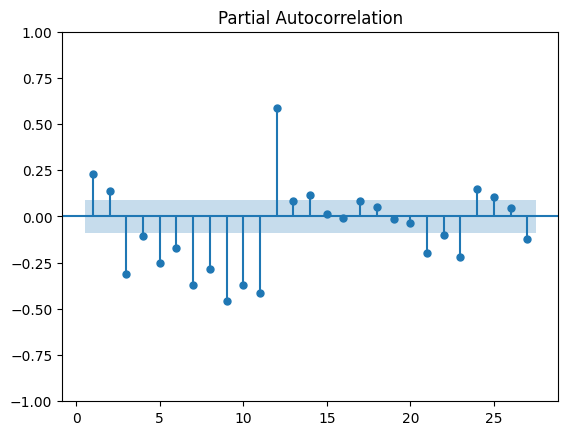

In [250]:
sgt.plot_pacf(df_diff, zero = False, method = ('OLS'))
plt.show()

---
=> To find the seasonal orders we plot the ACF and PACF of the differenced time series at multiple seasonal steps.

---

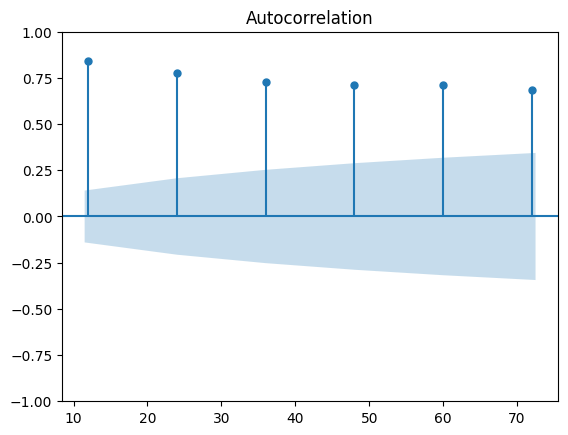

In [256]:
sgt.plot_acf(df_diff, lags = [12, 24, 36, 48, 60, 72])
plt.show()

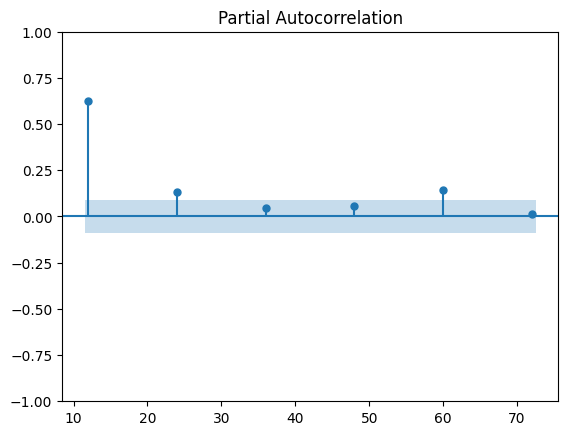

In [260]:
sgt.plot_pacf(df_diff, lags = [12, 24, 36, 48, 60, 72])
plt.show()

This plots the ACF and PACF at these specific lags only.

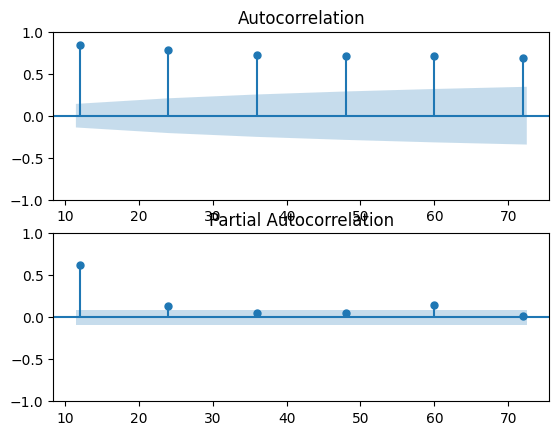

In [271]:
fig, (ax1, ax2) = plt.subplots(2, 1)
sgt.plot_acf(df_diff, lags = [12, 24, 36, 48, 60, 72], ax = ax1)
sgt.plot_pacf(df_diff, lags = [12, 24, 36, 48, 60, 72], ax = ax2)
plt.show()

### Searching over model orders

In [275]:
import pmdarima as pm

In [301]:
results = pm.auto_arima(df)

In [303]:
results

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [289]:
print(results)

 ARIMA(2,1,3)(0,0,0)[0]          


In [291]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  465
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1484.283
Date:                Sun, 02 Mar 2025   AIC                           2980.566
Time:                        07:52:20   BIC                           3005.405
Sample:                    04-01-1980   HQIC                          2990.343
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7280      0.003    537.995      0.000       1.722       1.734
ar.L2         -0.9951      0.003   -326.752      0.000      -1.001      -0.989
ma.L1         -2.3706      0.038    -62.838      0.0

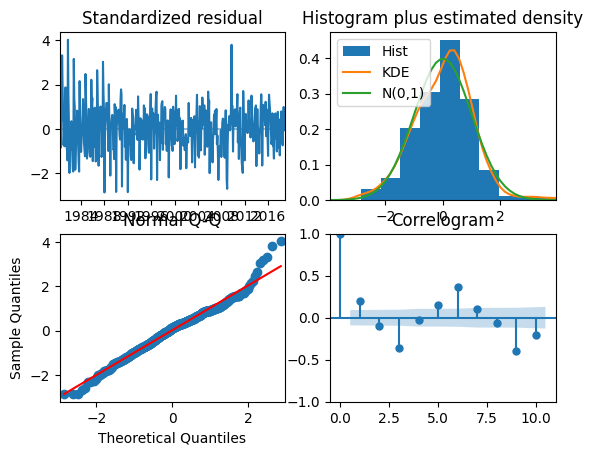

In [295]:
results.plot_diagnostics()
plt.show()

#### Non-Seasonal search parameters

In [321]:
results = pm.auto_arima(
    df, 
    d = 0,    # non-seasonal difference order
    start_p = 1,
    start_q = 1, 
    max_p = 3, 
    max_q = 3
)

In [323]:
results

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True)

In [311]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  465
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1540.965
Date:                Sun, 02 Mar 2025   AIC                           3093.930
Time:                        07:55:49   BIC                           3118.782
Sample:                    04-01-1980   HQIC                          3103.712
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3757      0.684      2.013      0.044       0.036       2.715
ar.L1          0.2574      0.045      5.701      0.000       0.169       0.346
ar.L2          0.7536      0.025     30.601      0.0

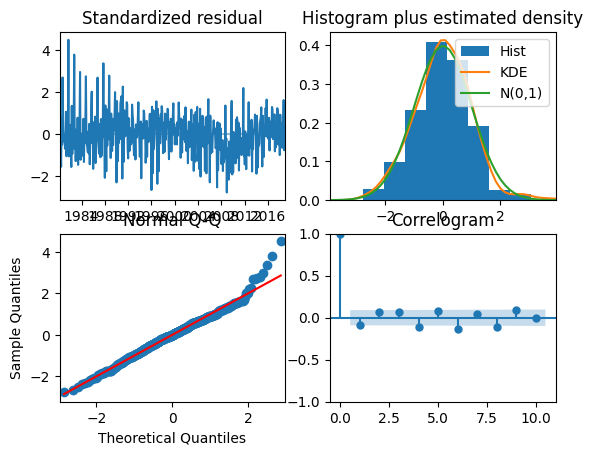

In [315]:
results.plot_diagnostics()
plt.show()

#### Seasonal search parameters

In [327]:
results = pm.auto_arima(df,
    d = 0,    # non-seasonal difference order
    start_p = 1,
    start_q = 1, 
    max_p = 3, 
    max_q = 3,
    seasonal = True, 
    m = 7, 
    D = 1, 
    start_P = 1, 
    start_Q = 1,
    max_P = 2, 
    max_Q = 2,
    information_criterion = 'aic', # used to select best model
    trace = True,  # print results whilst training
    error_action = 'ignore',  #ignore orders that don't work
    stepwise = True  # apply intelligent order search
                       )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4133.058, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3342.735, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4131.109, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3678.087, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=3292.252, Time=0.56 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=3264.034, Time=0.78 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=3414.203, Time=0.63 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=3231.788, Time=1.02 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3233.044, Time=0.69 s

In [329]:
results

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(2, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [331]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  465
Model:             SARIMAX(3, 0, 1)x(2, 1, 1, 7)   Log Likelihood               -1540.559
Date:                           Sun, 02 Mar 2025   AIC                           3097.118
Time:                                   08:04:12   BIC                           3130.132
Sample:                               04-01-1980   HQIC                          3110.120
                                    - 12-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0931      0.049     -1.891      0.059      -0.190       0.003
ar.L2          0.4940      0.046     10.821

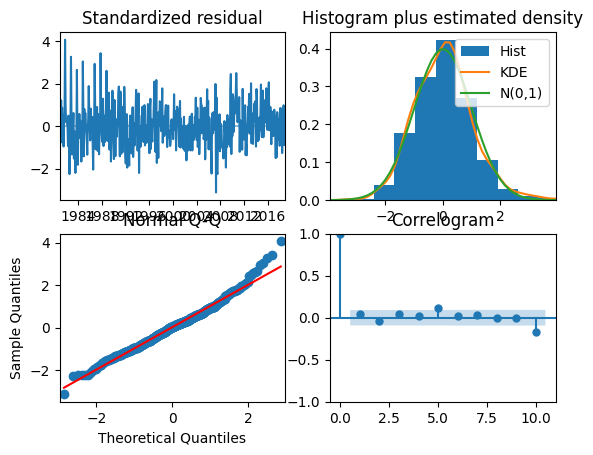

In [335]:
results.plot_diagnostics()
plt.show()

## Saving model objects

In [338]:
import joblib

In [350]:
current_path = Path.cwd()
current_path

WindowsPath('C:/Users/khali/Desktop/Jupyter/Time-Series')

In [352]:
current_file_path = 'C:/Users/khali/Desktop/Jupyter/Time-Series/great_model.pkl'

In [356]:
joblib.dump(results, current_file_path)

['C:/Users/khali/Desktop/Jupyter/Time-Series/great_model.pkl']

In [358]:
# loading model object from filepath
model_results_object = joblib.load(current_file_path)

In [366]:
model_results_object

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(2, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [374]:
# updating new observations and update parameters
model_results_object.update(df_diff) # df_diff is new

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(2, 1, 1, 7),
      suppress_warnings=True, with_intercept=False)

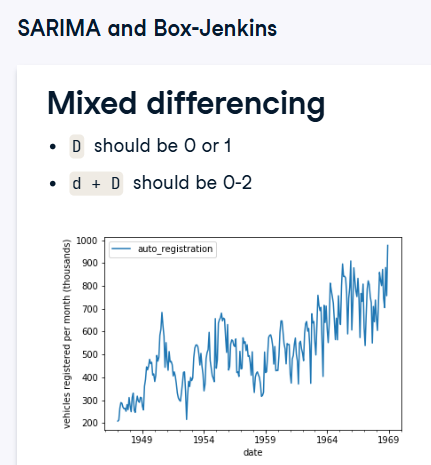
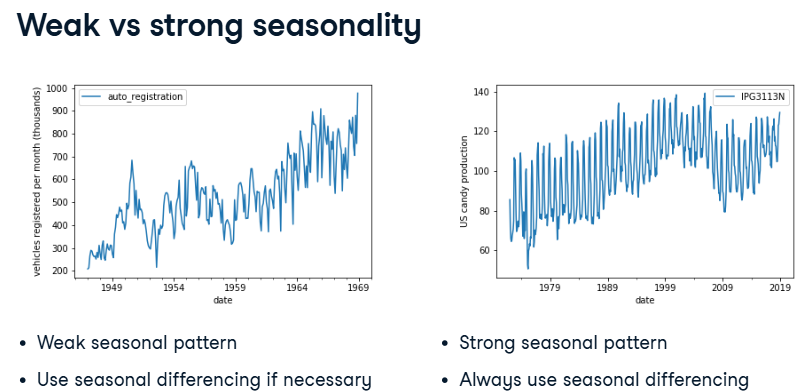

=> For time series on the right with strong seasonal pattern, you should always use one order of seasonal differencing. This will ensure that the seasonal oscillation will remain in your dynamic predictions far into the future without fading out.

=> Just like in ARIMA modeling sometimes we need to use other transformations on our time series before fitting.

---
=> Whenever the seasonality is additive we do not need to apply any transforms except differencing.\
=> Additive seasonality is where the seasonal pattern just adds or takes away a little from the trend.
- Additive series = trend + season
- Proceed as usual with differencing

---
=> When the seasonality is multiplicative, the SARIMA model can't fit this without extra transforms.\
=> If the seasonality is multiplicative, the amplitude of the seasonal oscillations will get larger as the data trends up or smaller as it trends down.\
=> To deal with this we take the log transform of the data before modeling it.
- multiplicative series = trend * season
- Apply log transform first - np.log

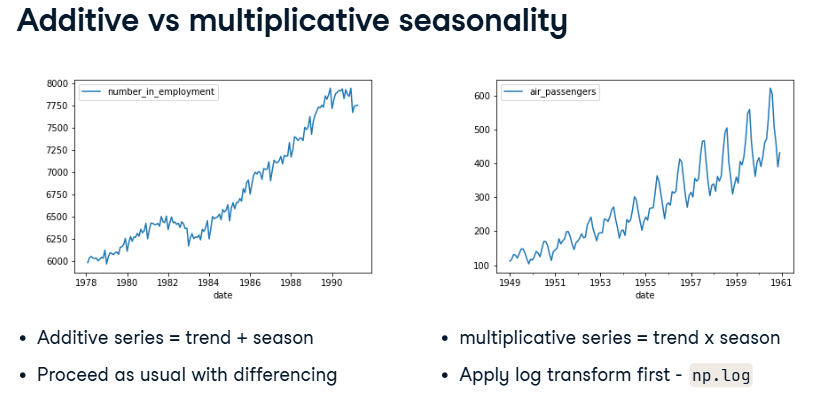

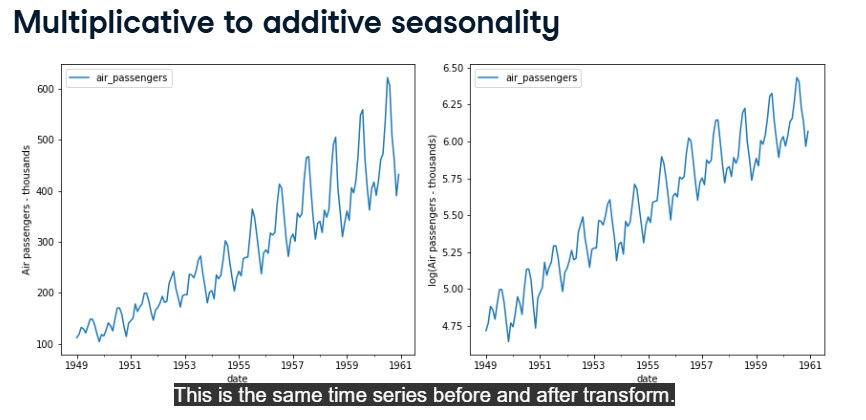

=> We can now model this using a normal SARIMA model with seasonal differencing.

Further steps:\
Fit data created using `arma_generate_sample()`